In [1]:
!python -V

Python 3.13.1


In [6]:
# Import libraries
import pandas as pd
import numpy as np
import datetime as dt

In [3]:
import pickle

In [7]:
# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics as mt

from sklearn.metrics import root_mean_squared_error

In [19]:
# Text processing and sentiment analysis
from textblob import TextBlob

In [12]:
df1 = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv')
df1.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [15]:
# Keep only relevant columns
df = df1[['Review Text', 'Rating', 'Class Name', 'Age']]
# Fill missing review texts with empty string
df = df.copy()
df['Review Text'] = df['Review Text'].fillna('')

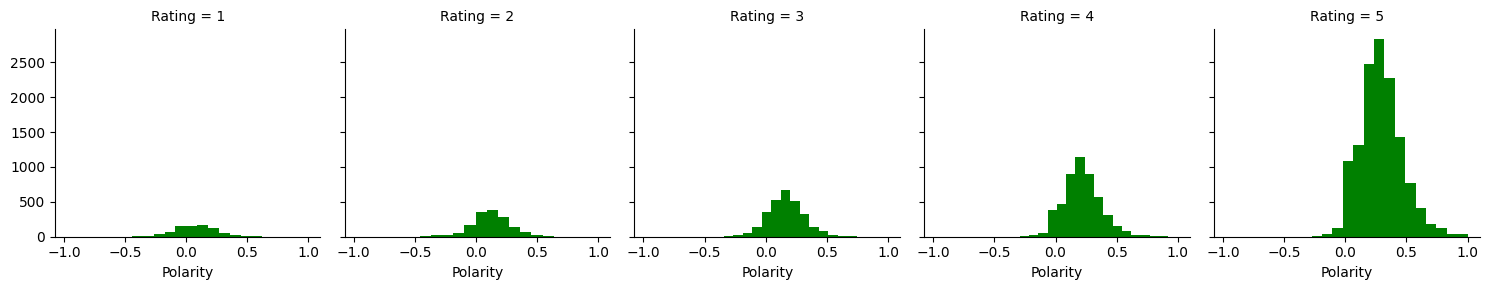

In [20]:
# Convert non-string values to empty strings or a placeholder
df1['Review Text'] = df1['Review Text'].astype(str)

# Now apply TextBlob to calculate Polarity
df1['Polarity'] = df1['Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)


g = sns.FacetGrid(df1, col="Rating", col_wrap=5)  
g = g.map(plt.hist, "Polarity", bins=20, color="g")

# Showing the plot
plt.show()

# Calculating the average polarity for each rating
rating_group = df1.groupby(['Rating'])  # Group by the 'Rating' column
average_polarity_rating = rating_group['Polarity'].mean()  

In [27]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()
analyzer = vectorizer.build_analyzer()

# Function to count words in each review
def wordcounts(s):
    c = {}
    if analyzer(s):
        d = {}
        w = vectorizer.fit_transform([s]).toarray()
        vc = vectorizer.vocabulary_
        for k, v in vc.items():
            d[v] = k
        for index, i in enumerate(w[0]):
            c[d[index]] = i
    return c

# Add word count dictionaries to new column
df['Word Counts'] = df['Review Text'].apply(wordcounts)

# Preview
df.head(5)

,Review Text,Rating,Class Name,Age,Word Counts
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ..."
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':..."
2,I had such high hopes for this dress and reall...,3,Dresses,60,"{'and': 3, 'be': 1, 'bottom': 1, 'but': 2, 'ch..."
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,"{'and': 1, 'but': 1, 'compliments': 1, 'every'..."
4,This shirt is very flattering to all due to th...,5,Blouses,47,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1..."


In [29]:
df = df[df['Rating'] != 3]  # Remove rows with a rating of 3
df = df.copy()
df['Sentiment'] = df['Rating'] >= 4  # Create a 'Sentiment' column, True for ratings >= 4, False otherwise
df.head()  # Display the first few rows of the modified DataFrame

,Review Text,Rating,Class Name,Age,Word Counts,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ...",True
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':...",True
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,"{'and': 1, 'but': 1, 'compliments': 1, 'every'...",True
4,This shirt is very flattering to all due to th...,5,Blouses,47,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1...",True
5,"I love tracy reese dresses, but this one is no...",2,Dresses,49,"{'0p': 1, 'alterations': 1, 'am': 1, 'and': 4,...",False


In [34]:
# Split the data into training and test sets (80% train, 20% test)
train_data, test_data = train_test_split(df, train_size=0.8, random_state=0)

# Initialize the vectorizer (using TF-IDF here for better performance with text)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Prepare the training and test data for the models
X_train = vectorizer.fit_transform(train_data['Review Text'])
y_train = train_data['Sentiment']
X_test = vectorizer.transform(test_data['Review Text'])
y_test = test_data['Sentiment']

In [37]:
# Start the timer
start = dt.datetime.now()
# Initialize and fit the Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=0)  # Specify max_iter to avoid convergence issues
lr.fit(X_train, y_train)

# Calculate elapsed time
elapsed_time = dt.datetime.now() - start

# Print the elapsed time
print('Elapsed time for Logistic Regression training: ', str(elapsed_time))

Elapsed time for Logistic Regression training:  0:00:00.079385


In [38]:
# Start the timer
start = dt.datetime.now()

# Initialize and fit the Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Calculate elapsed time
elapsed_time = dt.datetime.now() - start

# Print the elapsed time
print('Elapsed time for Multinomial Naive Bayes model training: ', str(elapsed_time))

Elapsed time for MultinomialNB training:  0:00:00.006493


In [39]:
# Start the timer
start = dt.datetime.now()

# Initialize and fit the Support Vector Machine model
svm = SVC()
svm.fit(X_train, y_train)

# Calculate elapsed time
elapsed_time = dt.datetime.now() - start

# Print the elapsed time
print('Elapsed time for Support Vector Machine model training: ', str(elapsed_time))

Elapsed time for SVC training:  0:00:42.817491


In [45]:
# Start the timer
start = dt.datetime.now()

# Initialize and fit the Multilayer Perceptron model
nn = MLPClassifier(max_iter=30)  # You can adjust max_iter if needed
nn.fit(X_train, y_train)

# Calculate elapsed time
elapsed_time = dt.datetime.now() - start

# Print the elapsed time
print('Elapsed time for Multilayer Perceptron model training: ', str(elapsed_time))

Elapsed time for Multilayer Perceptron model training:  0:00:16.641724


C:\Users\feife\.virtualenvs\feife-uGX0yjkr\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
# Start the timer
start = dt.datetime.now()

# Initialize and fit the Random Forest Classifier model
ran = RandomForestClassifier(n_estimators=50)
ran.fit(X_train, y_train)

# Calculate elapsed time
elapsed_time = dt.datetime.now() - start

# Print the elapsed time
print('Elapsed time for Random Forest Classifier model training: ', str(elapsed_time))

Elapsed time for Random Forest Classifier model training:  0:00:05.606364


In [46]:
# Generate confusion matrices for each model
lr_cm = confusion_matrix(y_test.values, lr.predict(X_test))
nb_cm = confusion_matrix(y_test.values, nb.predict(X_test))
svm_cm = confusion_matrix(y_test.values, svm.predict(X_test))
nn_cm = confusion_matrix(y_test.values, nn.predict(X_test))
ran_cm = confusion_matrix(y_test.values, ran.predict(X_test))  

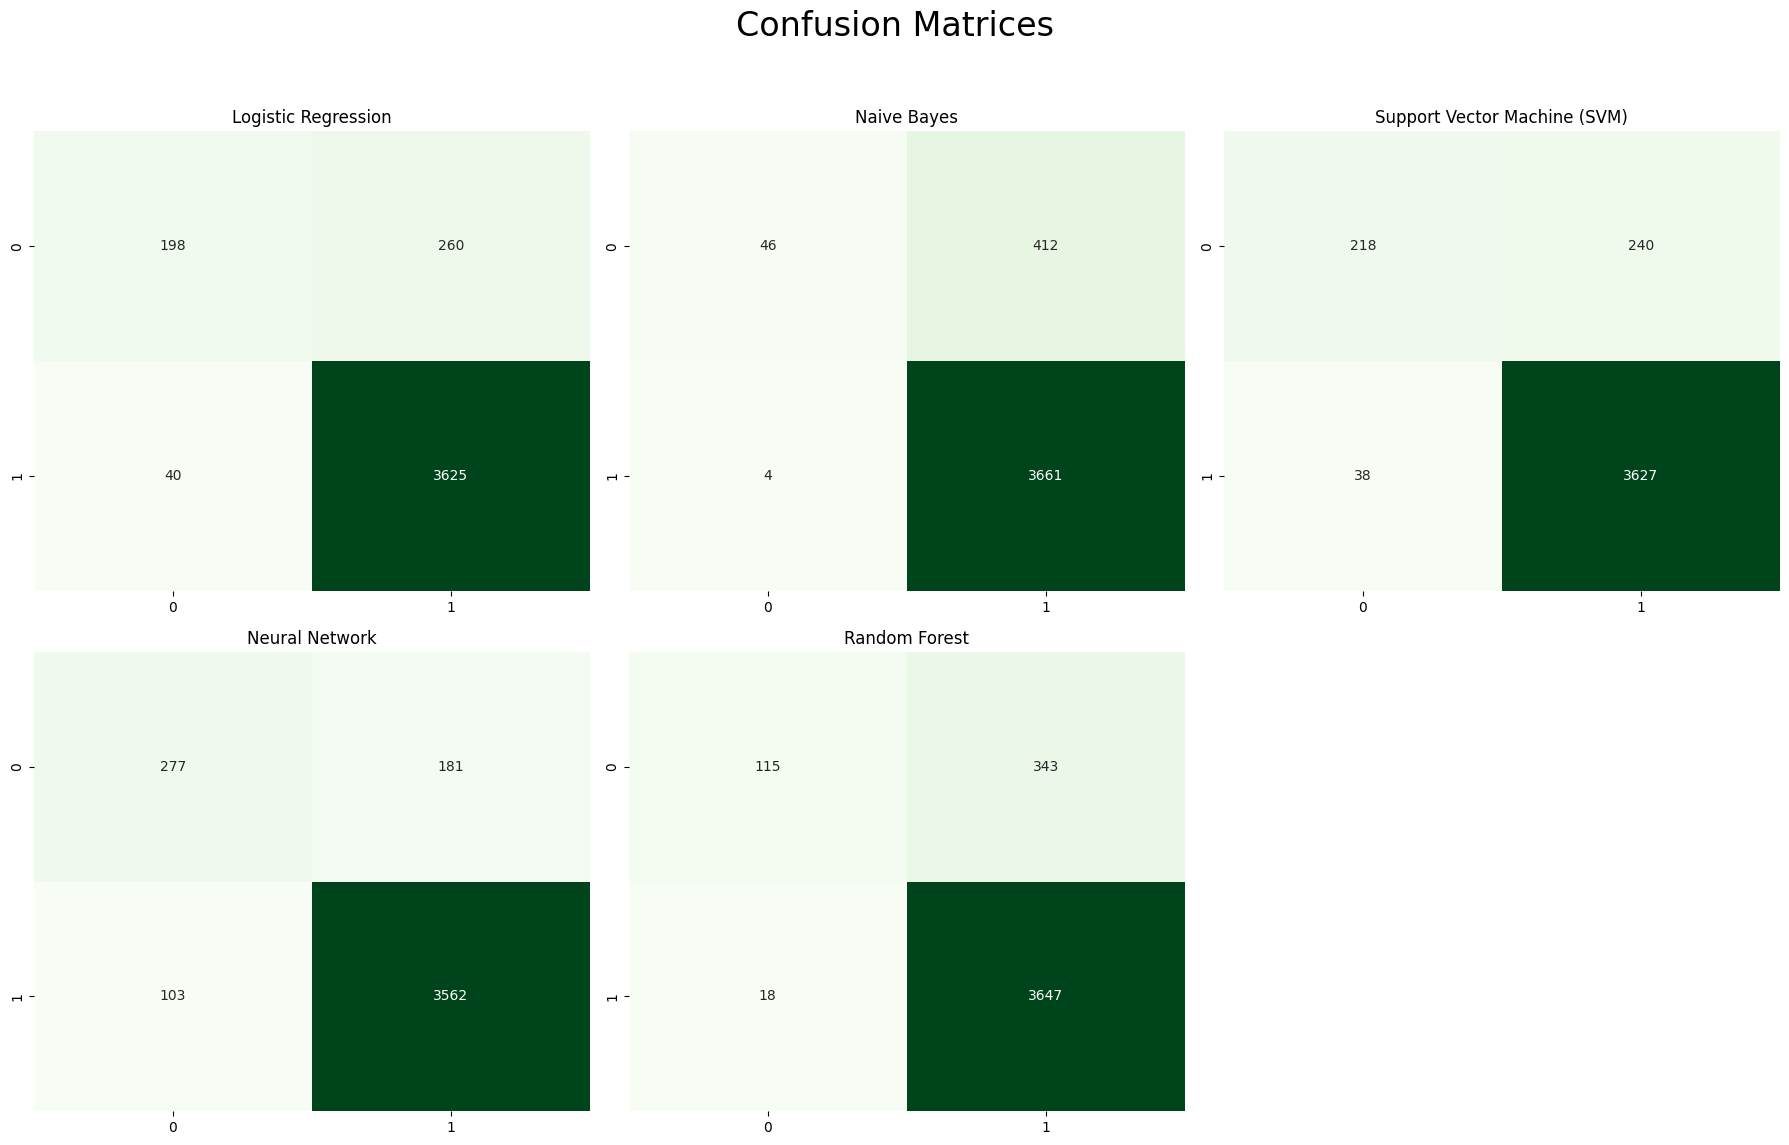

In [47]:
plt.figure(figsize=(18, 12))
plt.suptitle("Confusion Matrices", fontsize=24)

# Logistic Regression Confusion Matrix
plt.subplot(2, 3, 1)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, annot=True, cmap="Greens", cbar=False, fmt="d")

# Naive Bayes Confusion Matrix
plt.subplot(2, 3, 2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, annot=True, cmap="Greens", cbar=False, fmt="d")

# Support Vector Machine (SVM) Confusion Matrix
plt.subplot(2, 3, 3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, annot=True, cmap="Greens", cbar=False, fmt="d")

# Neural Network Confusion Matrix
plt.subplot(2, 3, 4)
plt.title("Neural Network")
sns.heatmap(nn_cm, annot=True, cmap="Greens", cbar=False, fmt="d")

# Random Forest Confusion Matrix
plt.subplot(2, 3, 5)
plt.title("Random Forest")
sns.heatmap(ran_cm, annot=True, cmap="Greens", cbar=False, fmt="d")

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlap with suptitle
plt.show()

In [50]:
# Logistic Regression Classification Report
print("Logistic Regression")
print(mt.classification_report(y_test, lr.predict(X_test)))

# Naive Bayes Classification Report
print("\nNaive Bayes")
print(mt.classification_report(y_test, nb.predict(X_test)))

# Support Vector Machine (SVM) Classification Report
print("\nSupport Vector Machine (SVM)")
print(mt.classification_report(y_test, svm.predict(X_test)))

# Neural Network Classification Report
print("\nNeural Network")
print(mt.classification_report(y_test, nn.predict(X_test)))
# Random Forest Classification Report
print("\nRandom Forest")
print(mt.classification_report(y_test, ran.predict(X_test)))

Logistic Regression
              precision    recall  f1-score   support

       False       0.83      0.43      0.57       458
        True       0.93      0.99      0.96      3665

    accuracy                           0.93      4123
   macro avg       0.88      0.71      0.76      4123
weighted avg       0.92      0.93      0.92      4123


Naive Bayes
              precision    recall  f1-score   support

       False       0.92      0.10      0.18       458
        True       0.90      1.00      0.95      3665

    accuracy                           0.90      4123
   macro avg       0.91      0.55      0.56      4123
weighted avg       0.90      0.90      0.86      4123


Support Vector Machine (SVM)
              precision    recall  f1-score   support

       False       0.85      0.48      0.61       458
        True       0.94      0.99      0.96      3665

    accuracy                           0.93      4123
   macro avg       0.89      0.73      0.79      4123
weighted av

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.479513631630414

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

11.167275941179728